In [1]:
import uproot
import pandas as pd
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def import_summary(tree):
    exclude_from_keys = [
        "measurementChi2",
        "outlierChi2",
        "measurementVolume",
        "measurementLayer",
        "outlierVolume",
        "outlierLayer",
    ]
    keys = [k for k in tree.keys() if not k in exclude_from_keys]

    event_df, multitraj_df, summary_df = ak.to_dataframe(tree.arrays(keys), how=None)

    flat_events, flat_multiTraj_nr = [], []
    
    event_iter = iter(event_df.event_nr)
    multitraj_iter = iter(multitraj_df.multiTraj_nr)
    
    for subTraj in summary_df.subTraj_nr:
        if subTraj == 0:
            current_multitraj = next(multitraj_iter)

            if current_multitraj == 0:
                current_event = next(event_iter)

        flat_events.append(current_event)
        flat_multiTraj_nr.append(current_multitraj)

    summary_df.insert(0, "multiTraj_nr", flat_multiTraj_nr)
    summary_df.insert(0, "event_nr", flat_events)

    return summary_df.reset_index(drop=True)

In [3]:
def compute_branches(summary, normalize=True):
    subtraj_count = summary.groupby(["event_nr", "multiTraj_nr"]).apply(lambda df: len(df))
    branches = np.zeros((max(summary.event_nr)+1, max(subtraj_count)+1))
    
    unique_subtraj_counts = subtraj_count.groupby(["event_nr",]).apply(lambda df: np.unique(df, return_counts=True))
    
    for event_nr, ((subtrajs, counts),) in pd.DataFrame(unique_subtraj_counts).iterrows():
        branches[event_nr][subtrajs] = counts

    if normalize:
        for i in range(branches.shape[0]):
            branches[i] /= np.sum(branches[i])

    return branches

In [4]:
tree = uproot.open("../tmp/no_threshold_2/tracksummary_gnn_plus_ckf.root:tracksummary")
summary_gnn_plus_ckf = import_summary(tree)

In [5]:
tree = uproot.open("../tmp/no_threshold_2/tracksummary_standard_ckf.root:tracksummary")
summary_standard_ckf = import_summary(tree)

In [6]:
branches_gnn_plus_ckf = compute_branches(summary_gnn_plus_ckf, False)
branches_standard_ckf = compute_branches(summary_standard_ckf, False)

Text(0.5, 0, 'number of subtrajectories')

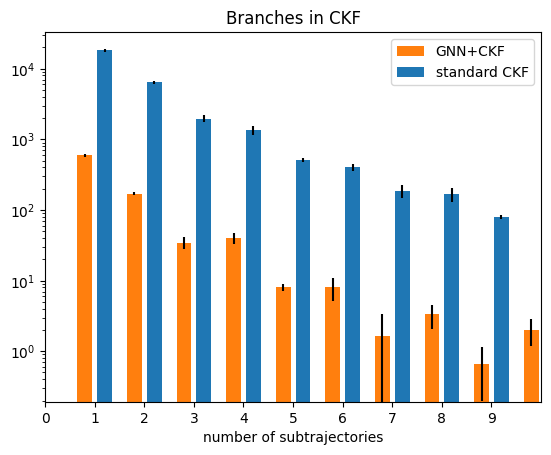

In [7]:
plt.title("Branches in CKF")
plt.bar(np.arange(branches_gnn_plus_ckf.shape[1])-0.2, np.mean(branches_gnn_plus_ckf, axis=0),
        width=0.3, yerr=np.std(branches_gnn_plus_ckf, axis=0), label="GNN+CKF", color="tab:orange")
plt.bar(np.arange(branches_standard_ckf.shape[1])+0.2, np.mean(branches_standard_ckf, axis=0),
        width=0.3, yerr=np.std(branches_standard_ckf, axis=0), label="standard CKF", color="tab:blue")
plt.xticks(np.arange(10))
plt.xlim(0,10)
#plt.ylim(0,1)
plt.legend()
plt.yscale('log')
plt.xlabel("number of subtrajectories")

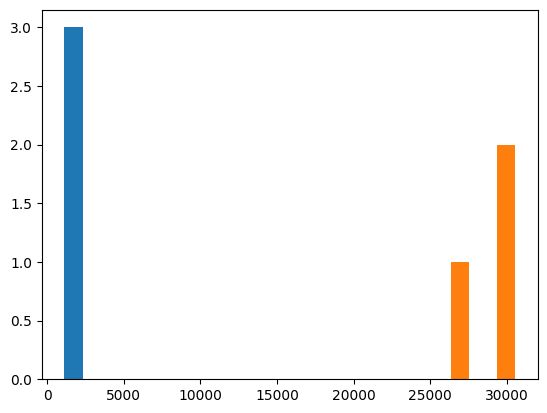

In [15]:
_ = plt.hist([
    summary_gnn_plus_ckf.groupby(["event_nr",]).apply(lambda df: max(df.multiTraj_nr)),
    summary_standard_ckf.groupby(["event_nr",]).apply(lambda df: max(df.multiTraj_nr)),
], bins=10)